In [1]:
import yaml
import pandas as pd
from pathlib import Path
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

from proteins.config import flatten_dict

ix = pd.IndexSlice
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 500)

In [2]:
from collections import defaultdict

df = defaultdict(list)
skip = []

for p in Path('.').glob('runs/*/*.yaml'):
    with open(p) as ex:
        ex = yaml.safe_load(ex)
    if ex['history'][-1]['status'] != 'COMPLETED':
        skip.append(p)
    else:
        df['misc', 'name', '', ''].append('_'.join(ex['fullname'].split('_')[-2:]))
        df['misc', 'time', '', ''].append((ex['history'][-1]['datetime_completed'] - ex['history'][-1]['datetime_started']).total_seconds() / 60)
        df['misc', 'gpu', '', ''].append(int(ex['history'][-1]['cuda']['devices']['cuda:0']['memory_used_max'].rstrip(' MiB')))
        df['hp', 'epochs', '', ''].append(ex['completed_epochs'])
        
        for k, v in flatten_dict(ex['data']):
            df[('hp', 'data', *k, '')].append(v)
        if 'residues' not in ex['data']:
            df[('hp', 'data', 'residues', '')].append(True)
        if 'residues' not in ex['data']:
            df[('hp', 'data', 'partial_entropy', '')].append(True)
        if 'residues' not in ex['data']:
            df[('hp', 'data', 'self_info', '')].append(True)
        if 'residues' not in ex['data']:
            df[('hp', 'data', 'dssp_features', '')].append(True)
            
        for k, v in flatten_dict(ex['model']):
            df[('hp', 'model', *k, '')].append(v)
            
        for k, v in flatten_dict(ex['optimizer']):
            df[('hp', 'optimizer', *k, '')].append(v)
        
        for k, v in flatten_dict(ex['loss']):
            df[('hp', 'loss', *k)].append(v)
        
        for k, v in flatten_dict(ex['history'][-1]['metric']):
            df[('metric', *k, '')].append(v)
                   
df = pd.DataFrame(df).sort_index(axis='columns', inplace=False)
        
print(f'Skipped {len(skip)}')
print(f'Good {len(df)}')
df.iloc[0].to_frame('Example')

Skipped 0
Good 113


Example
hp     data         cutoff                        8                          
                    dssp_features                 True                       
                    encoding_base                 0                          
                    encoding_size                 0                          
                    partial_entropy               True                       
                    residues                      True                       
                    self_info                     True                       
                    separation                    True                       
                    sigma                         15                         
       epochs                                     35                         
       loss         global_gdtts        balanced  False                      
                                        name      mse                        
                                        weight    5                          
                    global_lddt         balanced  False                      
                                        name      mse                        
                                        weight    1                          
                    local_lddt          balanced  False                      
                                        name      mse                        
                                        weight    1                          
       model        batch_norm                    True                       
                    dropout                       0.2                        
                    enc_in_edges                  8                          
                    enc_in_nodes                  83                         
                    fn                            proteins.networks.ProteinGN
                    layers                        8                          
                    mp_in_edges                   128                        
                    mp_in_globals                 512                        
                    mp_in_nodes                   512                        
                    mp_out_edges                  16                         
                    mp_out_globals                64                         
                    mp_out_nodes                  64                         
       optimizer    fn                            torch.optim.Adam           
                    lr                            0.001                      
                    weight_decay                  1e-05                      
metric global_gdtts first_rank_loss               0.0540286                  
                    kendall                       0.783501                   
                    pearson                       0.935205                   
                    per_target_kendall            0.628145                   
                    per_target_pearson            0.863953                   
                    per_target_spearman           0.790159                   
                    rmse                          0.100257                   
                    spearman                      0.937395                   
       global_lddt  first_rank_loss               0.0296429                  
                    kendall                       0.76443                    
                    pearson                       0.906568                   
                    per_target_kendall            0.664403                   
                    per_target_pearson            0.833493                   
                    per_target_spearman           0.82717                    
                    rmse                          0.0850096                  
                    spearman                      0.912503                   
       local_lddt   pearson                       0.849287                   
              

In [3]:
fixed_hps = df.hp.nunique() == 1
display(df.hp.loc[[0], fixed_hps.values].rename(index={0:'Fixed parameters'}))

# Always keep these because we plot them later
keep = {'cutoff', 'dropout', 'layers', 'separation'}
df.drop(columns=(('hp', *c) for c in fixed_hps[fixed_hps.values].index.remove_unused_levels() if c[1] not in keep), inplace=True)
df.columns = df.columns.remove_unused_levels()
df.sort_index(axis='columns', inplace=True)

data                                                   \
                 cutoff dssp_features partial_entropy residues self_info   
                                                                           
Fixed parameters  8      True          True            True     True       

                            epochs         loss                               \
                 separation        global_gdtts             global_lddt        
                                       balanced name weight    balanced name   
Fixed parameters  True       35     False        mse  5      False       mse   

                                               model  \
                        local_lddt      enc_in_edges   
                 weight   balanced name                
Fixed parameters  1      False      mse  8             

                                                                       \
                                           fn mp_in_edges mp_in_nodes   
                                                                        
Fixed parameters  proteins.networks.ProteinGN  128         512          

                         optimizer                      
                                fn     lr weight_decay  
                                                        
Fixed parameters  torch.optim.Adam  0.001  0.00001

In [4]:
display(df[df.metric.isna().any(axis=1)]
        .style
        .set_caption('<h3 align="left"> Something went wrong here </h3>')
        .applymap(lambda v: 'color: red' if pd.isna(v) else '', subset=['metric'])
        .hide_index()
)
df.dropna(subset=[c for c in df.columns if c[0] == 'metric'], how='any', axis='index', inplace=True)

In [5]:
too_high_rmse = (df.loc[:, ix['metric', :, 'rmse']] > .2).any(axis='columns')
display(df[too_high_rmse].style.set_caption('<h3 align="left"> RMSE too high </h3>').hide_index())
df=df[~too_high_rmse]

## What's the best we can do?

In [6]:
idx_best = pd.concat((
    df[[c for c in df.columns if c[0] == 'metric' and c[2].endswith('pearson')]].idxmax(), 
    df[[c for c in df.columns if c[0] == 'metric' and c[2].startswith('first')]].idxmin()
)).sort_index(ascending=False).droplevel(0)

best = df.loc[idx_best, :]
best.index = idx_best.index
best = best.transpose()
s = best.style
for r in s.index:
    if r[0] == 'metric':
        if 'rank' in r[2] or 'rmse' in r[2]:
            s.apply(lambda x: ['color: orange; font-weight: bold' if v == x.min() else '' for v in x], subset=ix[r], axis=1)
        else:
            s.apply(lambda x: ['color: green; font-weight: bold' if v == x.max() else '' for v in x], subset=ix[r], axis=1)
s

In [7]:
idx_best = pd.concat((
    df[[c for c in df.columns if c[0] == 'metric' and c[2].endswith('pearson')]].idxmax(), 
    df[[c for c in df.columns if c[0] == 'metric' and c[2].startswith('first')]].idxmin()
)).sort_index(ascending=False).droplevel(0)

best = df.loc[idx_best, :]
best.index = idx_best.index
best = best.transpose()
s = best.style
for r in s.index:
    if r[0] == 'metric':
        if 'rank' in r[2] or 'rmse' in r[2]:
            s.apply(lambda x: ['color: orange; font-weight: bold' if v == x.min() else '' for v in x], subset=ix[r], axis=1)
        else:
            s.apply(lambda x: ['color: green; font-weight: bold' if v == x.max() else '' for v in x], subset=ix[r], axis=1)
s

In [8]:
def highlight_max(data):
    attr = 'color: green; font-weight: bold'
    m = data.values.max()
    if data.ndim == 1:  # Series
        return pd.Series(np.where(data == m, attr, ''), index=data.index)
    else:  # DataFrame
        return pd.DataFrame(np.where(data == m, attr, ''), index=data.index, columns=data.columns)

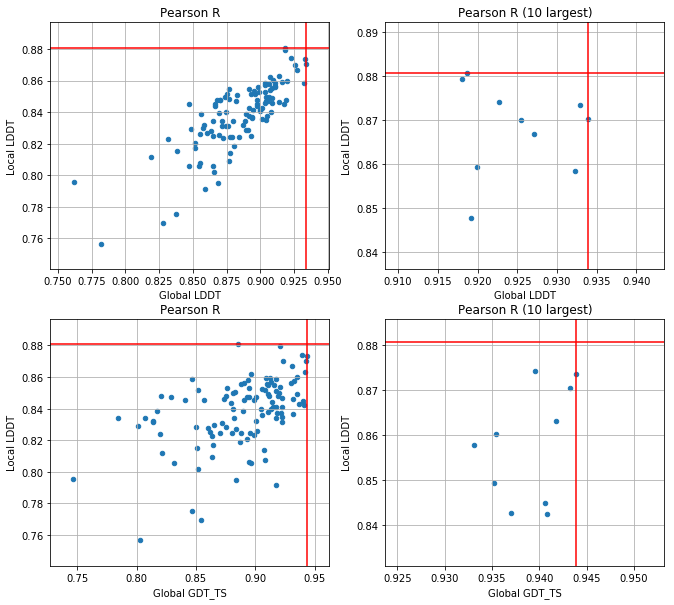

In [9]:
fig, axes = plt.subplots(2,2, figsize=(11, 10))

ax = axes.flat[0]
df.plot.scatter(ix['metric', 'global_lddt', 'pearson'], ix['metric', 'local_lddt', 'pearson'], ax=ax)
ax.set_title('Pearson R')
ax.set_xlabel('Global LDDT')
ax.set_ylabel('Local LDDT')
ax.axhline(df['metric', 'local_lddt', 'pearson'].max(), c='r')
ax.axvline(df['metric', 'global_lddt', 'pearson'].max(), c='r')
ax.grid()

ax = axes.flat[1]
df.nlargest(10, [ix['metric', 'global_lddt', 'pearson'], ix['metric', 'local_lddt', 'pearson']]).plot.scatter(ix['metric', 'global_lddt', 'pearson'], ix['metric', 'local_lddt', 'pearson'], ax=ax)
ax.set_title('Pearson R (10 largest)')
ax.set_xlabel('Global LDDT')
ax.set_ylabel('Local LDDT')
ax.axhline(df['metric', 'local_lddt', 'pearson'].max(), c='r')
ax.axvline(df['metric', 'global_lddt', 'pearson'].max(), c='r')
ax.grid()

ax = axes.flat[2]
df.plot.scatter(ix['metric', 'global_gdtts', 'pearson'], ix['metric', 'local_lddt', 'pearson'], ax=ax)
ax.set_title('Pearson R')
ax.set_xlabel('Global GDT_TS')
ax.set_ylabel('Local LDDT')
ax.axhline(df['metric', 'local_lddt', 'pearson'].max(), c='r')
ax.axvline(df['metric', 'global_gdtts', 'pearson'].max(), c='r')
ax.grid()

ax = axes.flat[3]
df.nlargest(10, [ix['metric', 'global_gdtts', 'pearson'], ix['metric', 'local_lddt', 'pearson']]).plot.scatter(ix['metric', 'global_gdtts', 'pearson'], ix['metric', 'local_lddt', 'pearson'], ax=ax)
ax.set_title('Pearson R (10 largest)')
ax.set_xlabel('Global GDT_TS')
ax.set_ylabel('Local LDDT')
ax.axhline(df['metric', 'local_lddt', 'pearson'].max(), c='r')
ax.axvline(df['metric', 'global_gdtts', 'pearson'].max(), c='r')
ax.grid()

In [10]:
best_local_lddt = (
    df.nlargest(5, [ix['metric', 'local_lddt', 'per_model_pearson']])
    .drop(columns=[c for c in df.columns.get_values() if 'kendall' in c[2] or 'spearman' in c[2]])
    .rename(columns=lambda s: s.replace('mp_', ''), level=2)
    .rename(columns=lambda s: s.replace('encoding_', 'enc_'), level=2)
    .rename(columns=lambda s: s.replace('dropout', 'drop'), level=2)
    .rename(columns=lambda s: s.replace('per_target_pearson', 'R_tar'), level=2)
    .rename(columns=lambda s: s.replace('per_model_pearson', 'R_mod'), level=2)
    .rename(columns=lambda s: s.replace('pearson', 'R'), level=2)
    .rename(columns=lambda s: s.replace('first_rank_loss', 'FRL'), level=2)
)
display(
    best_local_lddt.style
    .highlight_max(color='""; color: green; font-weight: bold;', subset=[c for c in best_local_lddt.columns.get_values() if 'metric' in c and 'FRL' not in c])
    .highlight_min(color='""; color: orange; font-weight: bold;', subset=[c for c in best_local_lddt.columns.get_values() if 'metric' in c and 'FRL' in c])
    .set_precision(3)
    .set_table_styles([{'selector': 'th', 'props': [('text-align', 'left')]}])
    .set_caption('<h3 align="left">Best Local LDDT Per Model Pearson</h3>')
    .hide_index()
)

best_global_lddt = (
    df.nlargest(5, [ix['metric', 'global_lddt', 'per_target_pearson']])
    .drop(columns=[c for c in df.columns.get_values() if 'kendall' in c[2] or 'spearman' in c[2]])
    .rename(columns=lambda s: s.replace('mp_', ''), level=2)
    .rename(columns=lambda s: s.replace('encoding_', 'enc_'), level=2)
    .rename(columns=lambda s: s.replace('dropout', 'drop'), level=2)
    .rename(columns=lambda s: s.replace('per_target_pearson', 'R_tar'), level=2)
    .rename(columns=lambda s: s.replace('per_model_pearson', 'R_mod'), level=2)
    .rename(columns=lambda s: s.replace('pearson', 'R'), level=2)
    .rename(columns=lambda s: s.replace('first_rank_loss', 'FRL'), level=2)
)
display(
    best_global_lddt.style
    .highlight_max(color='""; color: green; font-weight: bold;', subset=[c for c in best_global_lddt.columns.get_values() if 'metric' in c and 'FRL' not in c])
    .highlight_min(color='""; color: orange; font-weight: bold;', subset=[c for c in best_global_lddt.columns.get_values() if 'metric' in c and 'FRL' in c])
    .set_precision(3)
    .set_table_styles([{'selector': 'th', 'props': [('text-align', 'left')]}])
    .set_caption('<h3 align="left">Best Global LDDT Per Target Pearson</h3>')
    .hide_index()
)

best_global_gdtts = (
    df.nlargest(5, [ix['metric', 'global_gdtts', 'per_target_pearson']])
    .drop(columns=[c for c in df.columns.get_values() if 'kendall' in c[2] or 'spearman' in c[2]])
    .rename(columns=lambda s: s.replace('mp_', ''), level=2)
    .rename(columns=lambda s: s.replace('encoding_', 'enc_'), level=2)
    .rename(columns=lambda s: s.replace('dropout', 'drop'), level=2)
    .rename(columns=lambda s: s.replace('per_target_pearson', 'R_tar'), level=2)
    .rename(columns=lambda s: s.replace('per_model_pearson', 'R_mod'), level=2)
    .rename(columns=lambda s: s.replace('pearson', 'R'), level=2)
    .rename(columns=lambda s: s.replace('first_rank_loss', 'FRL'), level=2)
)
display(
    best_global_lddt.style
    .highlight_max(color='""; color: green; font-weight: bold;', subset=[c for c in best_global_gdtts.columns.get_values() if 'metric' in c and 'FRL' not in c])
    .highlight_min(color='""; color: orange; font-weight: bold;', subset=[c for c in best_global_gdtts.columns.get_values() if 'metric' in c and 'FRL' in c])
    .set_precision(3)
    .set_table_styles([{'selector': 'th', 'props': [('text-align', 'left')]}])
    .set_caption('<h3 align="left">Best Global GDT_TS Per Target Pearson</h3>')
    .hide_index()
)

## Resources usage

In [11]:
for resource in ['time', 'gpu']:
    display(
        df.nlargest(10, ix['misc', resource])
        .sort_index(axis='columns', level=0, sort_remaining=False, ascending=False)
        .rename(columns=lambda s: s.replace('mp_', ''), level=2)
        .rename(columns=lambda s: s.replace('nodes', 'n'), level=2)
        .rename(columns=lambda s: s.replace('globals', 'g'), level=2)
        .rename(columns=lambda s: s.replace('edges', 'e'), level=2)
        .rename(columns=lambda s: s.replace('encoding', 'enc'), level=2)
        .rename(columns=lambda s: s.replace('encoding_', 'enc_'), level=2)
        .rename(columns=lambda s: s.replace('dropout', 'drop'), level=2)
        .drop(columns=['metric'], level=0)
        .style
        .background_gradient(subset=[ix['misc', resource, '', '']])
        .hide_index()
    )

## How do RMSE and Pearson R correlate?

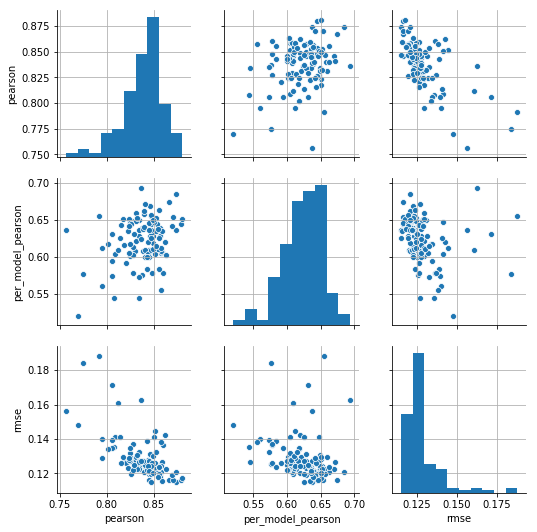

In [12]:
pg = sns.pairplot(df['metric', 'local_lddt'].droplevel(-1, axis='columns'))
for ax in pg.axes.ravel():
    ax.grid()

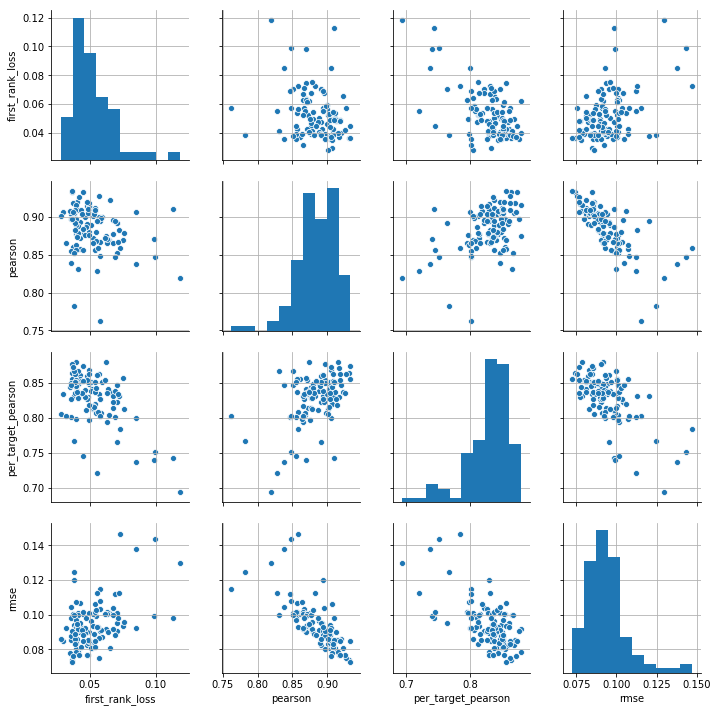

In [13]:
pg = sns.pairplot(df['metric', 'global_lddt'].drop(columns=['kendall', 'spearman', 'per_target_kendall', 'per_target_spearman']).droplevel(-1, axis='columns'))
for ax in pg.axes.ravel():
    ax.grid()

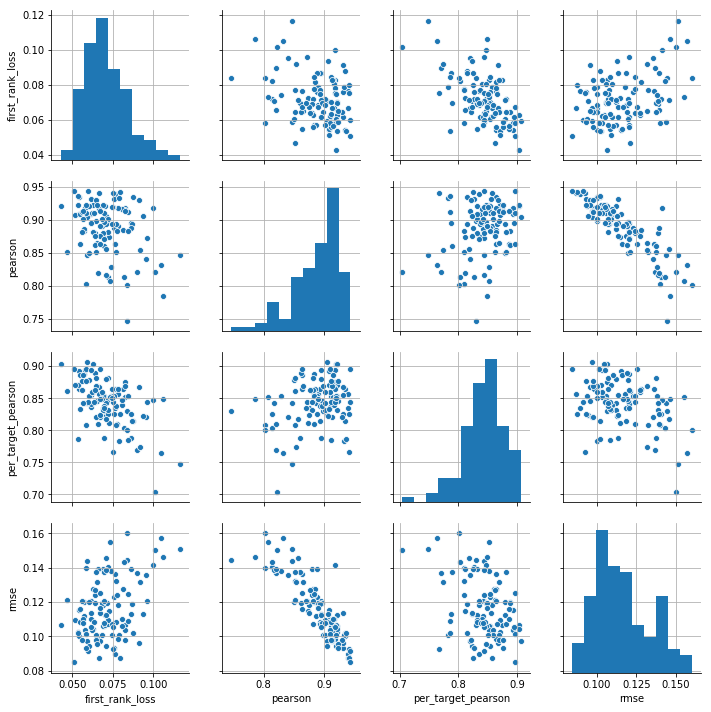

In [14]:
pg = sns.pairplot(df['metric', 'global_gdtts'].drop(columns=['kendall', 'spearman', 'per_target_kendall', 'per_target_spearman']).droplevel(-1, axis='columns'))
for ax in pg.axes.ravel():
    ax.grid()

## Global vs local

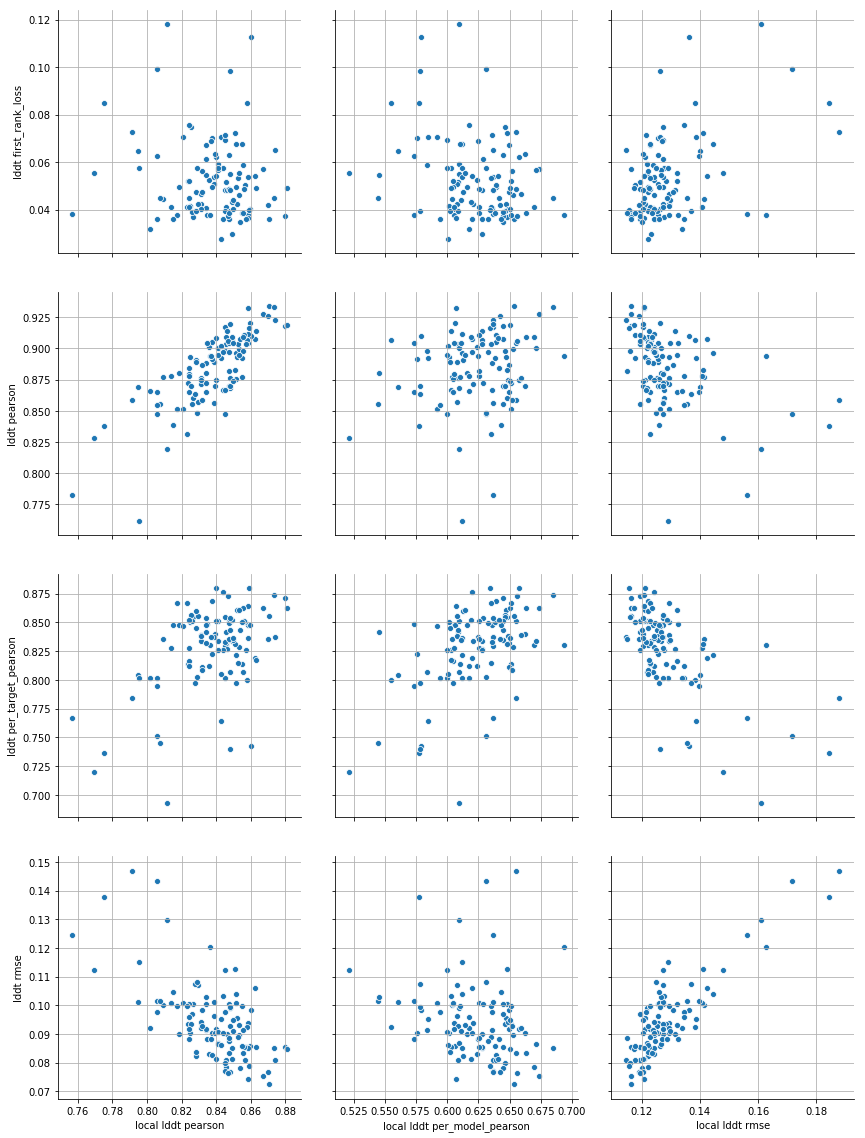

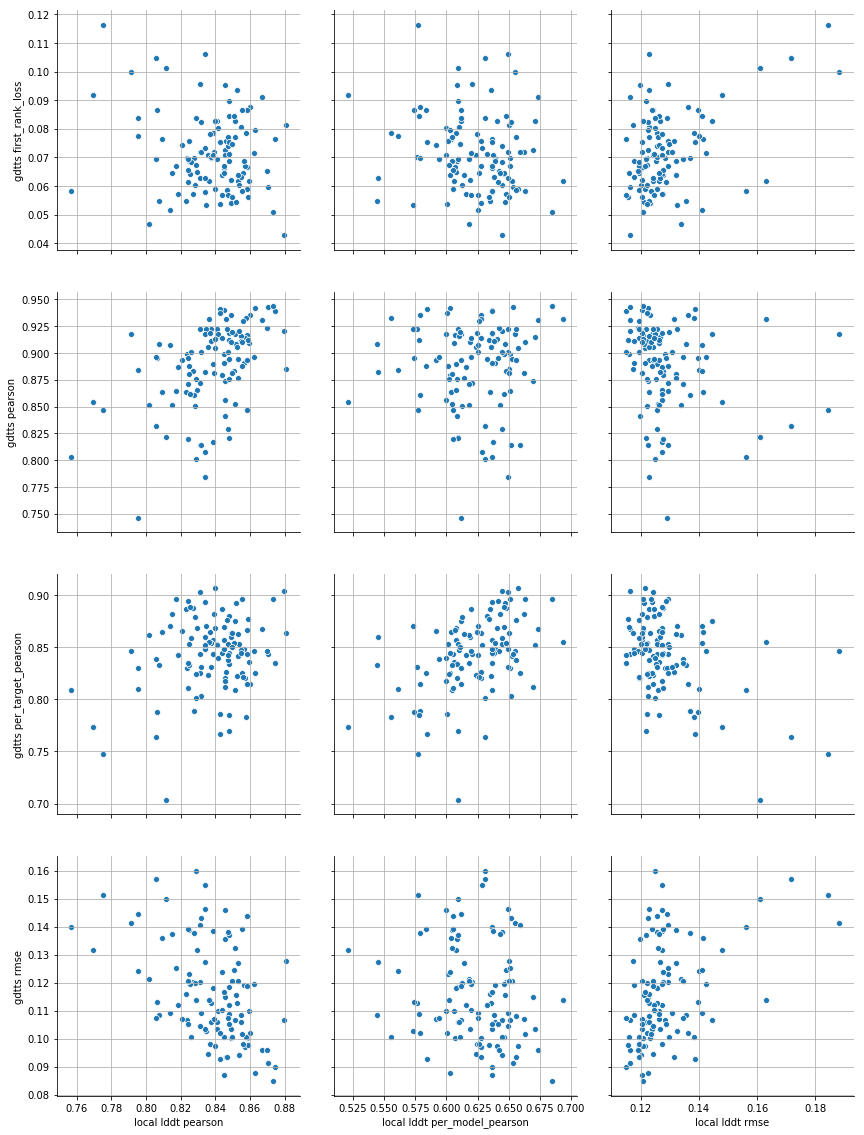

In [15]:
for g in ('global_lddt', 'global_gdtts'):
    pg = sns.pairplot(
        df, 
        height=4,
        y_vars=list(c for c in df.columns if c[0] == 'metric' and c[1] == g and 'spearman' not in c[2] and 'kendall' not in c[2]),
        x_vars=list(c for c in df.columns if c[0] == 'metric' and c[1] == 'local_lddt' and 'spearman' not in c[2] and 'kendall' not in c[2])
    )
    
    for ax in pg.axes.ravel():
        ax.grid()
        if len(ax.get_xlabel()) > 0:
            ax.set_xlabel('local lddt ' + ax.get_xlabel().split("'")[5])
        if len(ax.get_ylabel()) > 0:
            split = ax.get_ylabel().split("'")
            ax.set_ylabel(f'{split[3][7:]} {split[5]}')

## Parameters

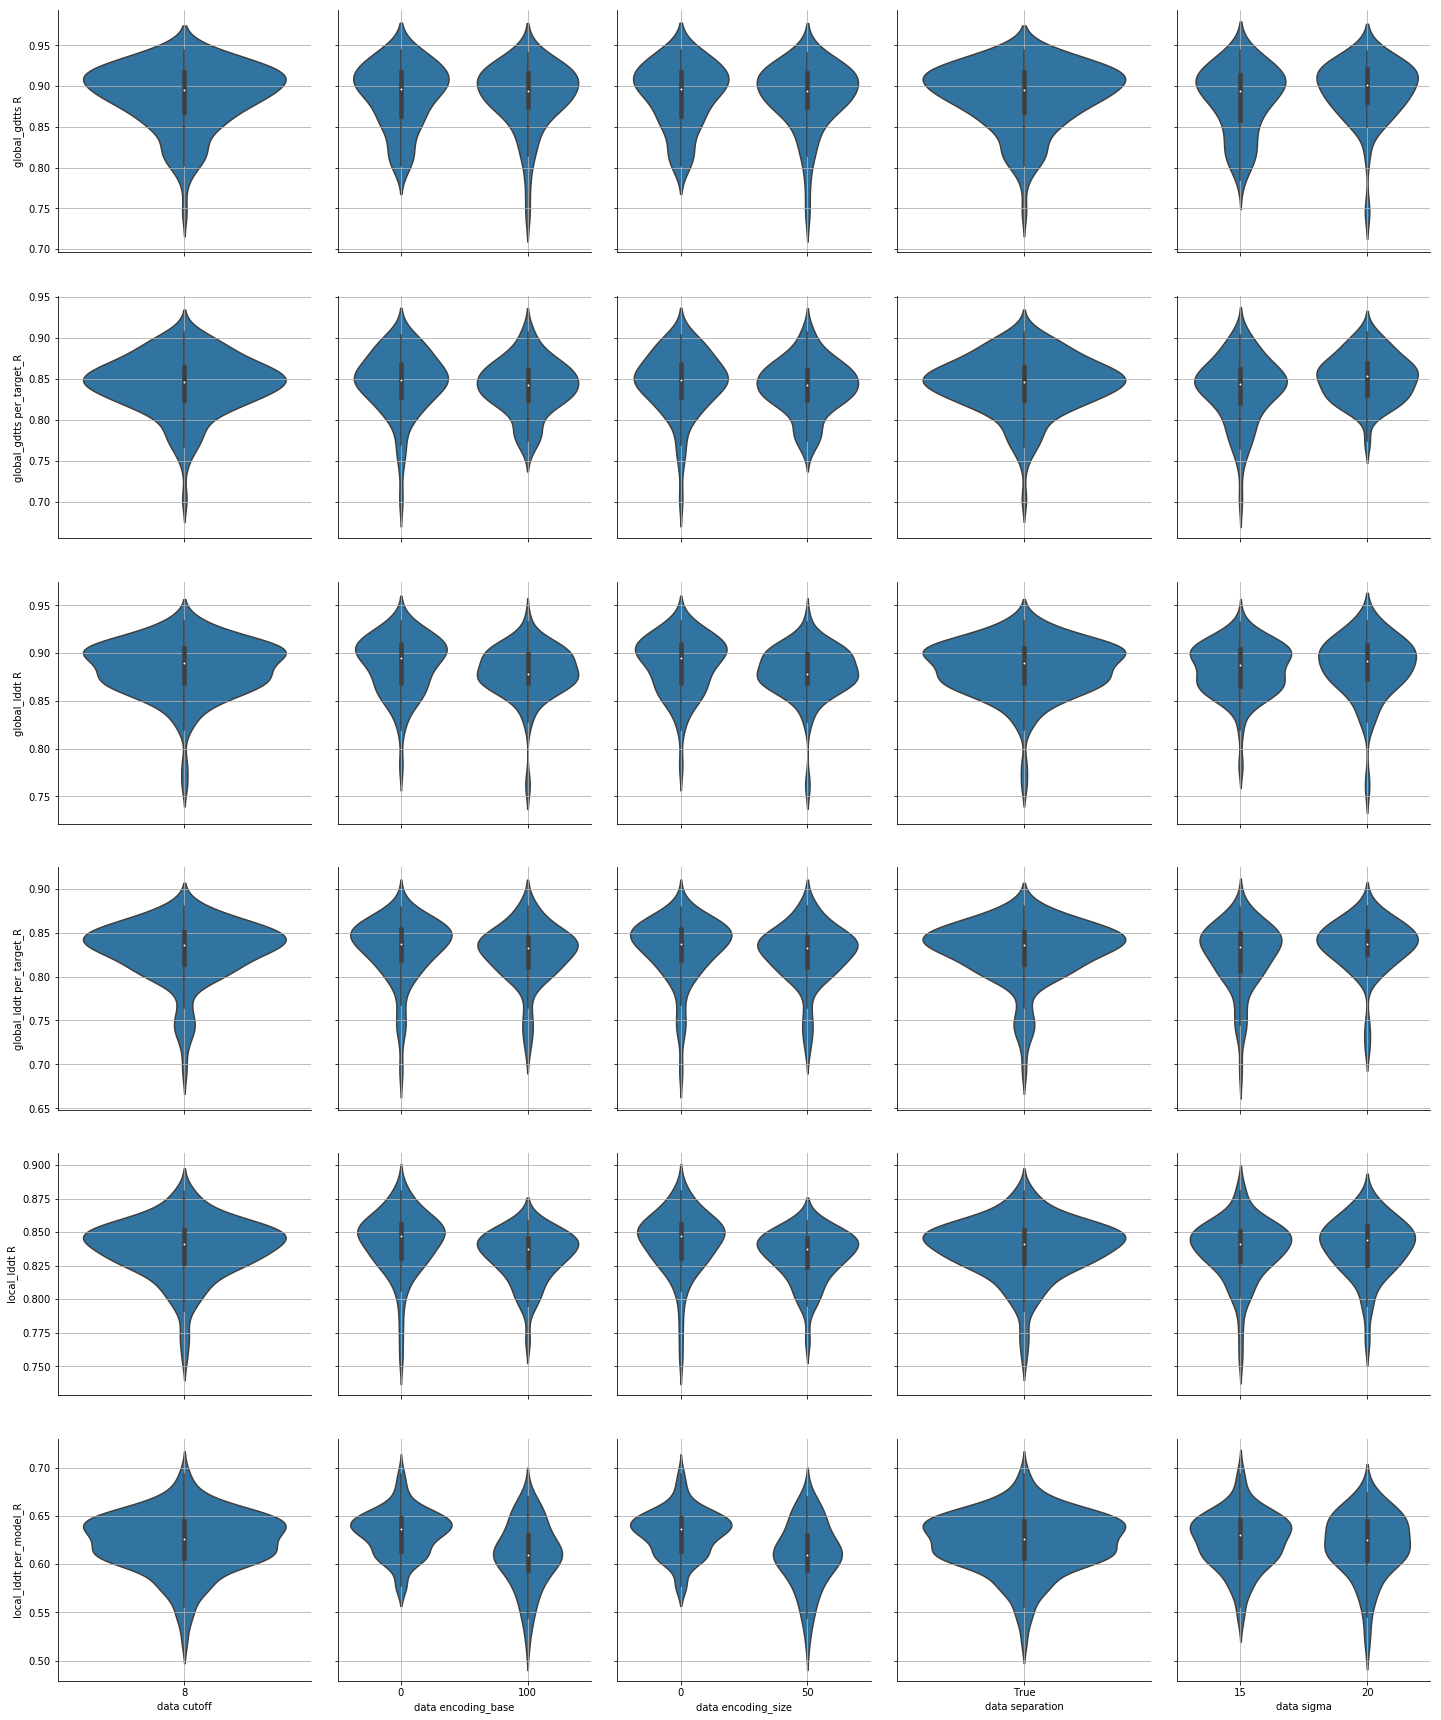

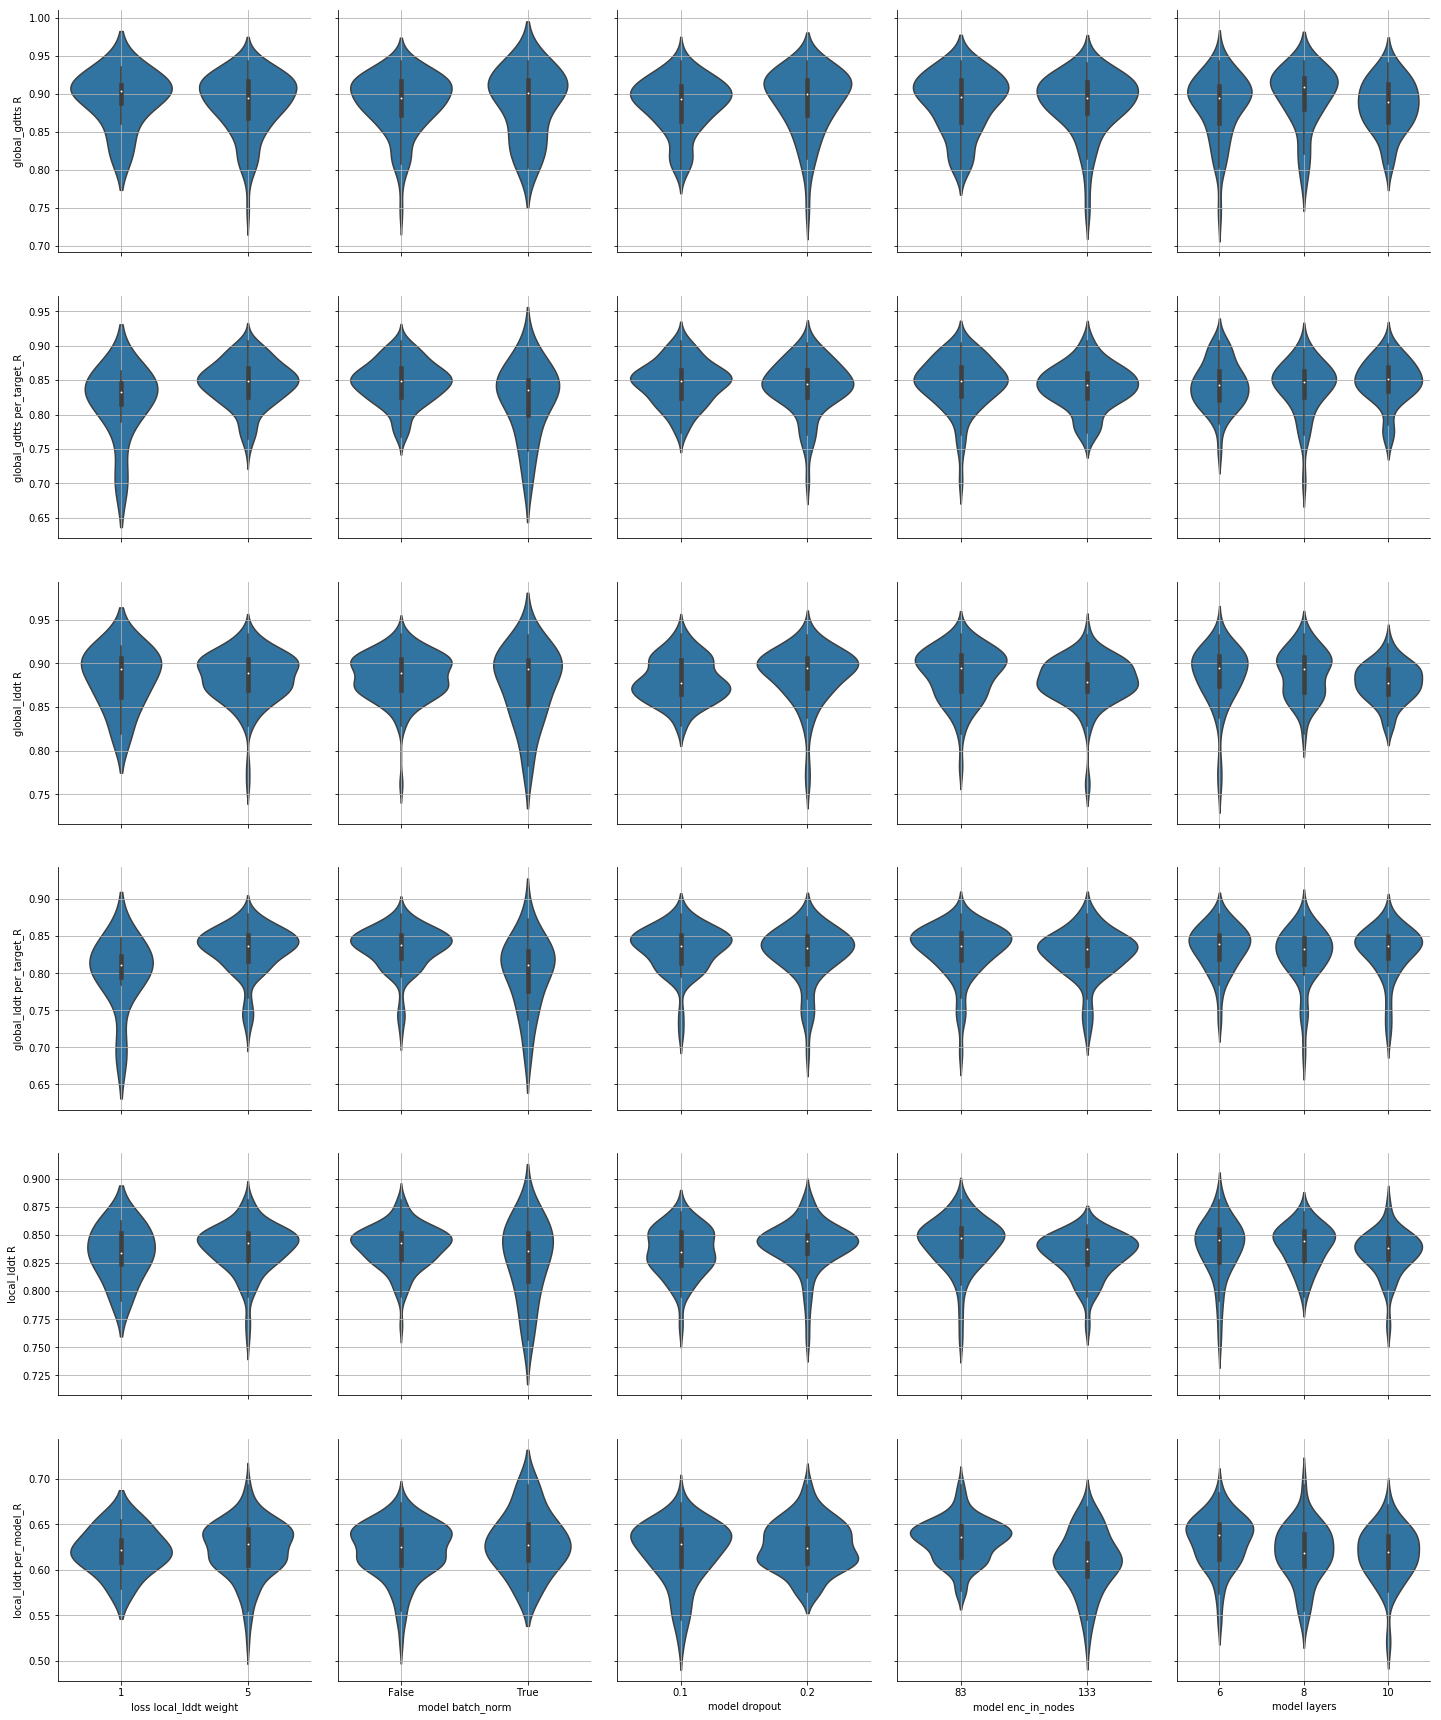

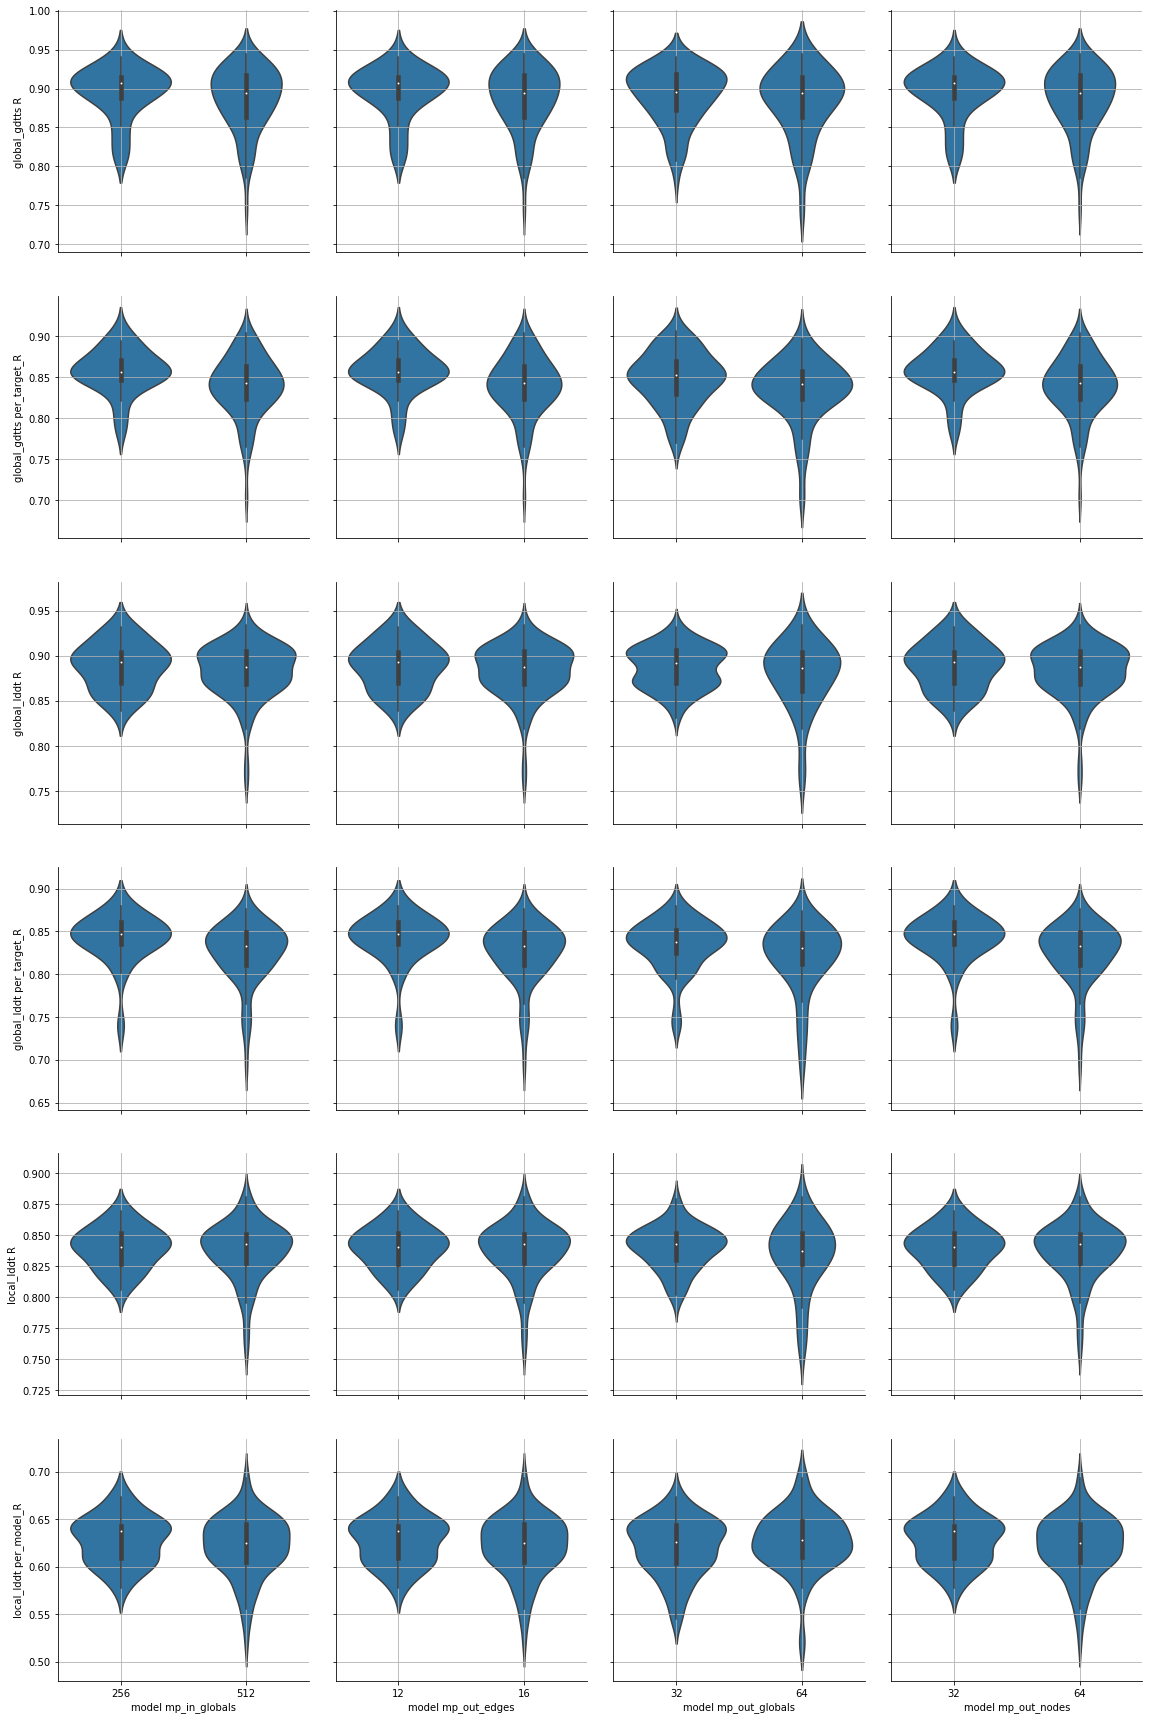

In [16]:
metrics = list(c for c in df.columns if c[0] == 'metric' and c[2].endswith('pearson'))
hps = list(c for c in df.columns if c[0] == 'hp')

for i in range(0, len(hps), 5):
    pg = sns.PairGrid(
        df[(df['metric'] > 0).all(axis=1)],
        height=4,
        y_vars=metrics,
        x_vars=hps[i: i+5],
    )
    pg.map(sns.violinplot)
    for ax in pg.axes.ravel():
        ax.grid()
    for ax, name in zip(pg.axes[-1, :], (' '.join(hp[1:]).strip() for hp in hps[i: i+5])):
        ax.set_xlabel(name)
    for ax, name in zip(pg.axes[:, 0], (m[1] + ' ' + m[2].replace('pearson', 'R') for m in metrics)):
        ax.set_ylabel(name)

### Layers vs cutoff (group by and take best)
- 6 layers seems good

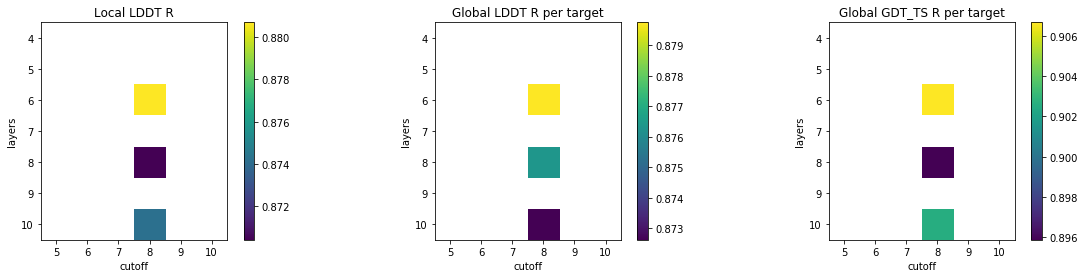

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(20,4))

df_cutoff_layers = df.groupby(by=[ix['hp', 'data', 'cutoff'], ix['hp', 'model', 'layers']]) \
    .apply(lambda df: df.metric.max()) \
    .reindex(pd.MultiIndex.from_product([range(5,11), range(4, 11)], names=['cutoff', 'layers'])) \
    .unstack('cutoff')

metrics = {
    'Local LDDT R': df_cutoff_layers['local_lddt', 'pearson'], 
    'Global LDDT R per target': df_cutoff_layers['global_lddt', 'per_target_pearson'], 
    'Global GDT_TS R per target': df_cutoff_layers['global_gdtts', 'per_target_pearson'], 
}

for ax, (title, df_img) in zip(axes, metrics.items()):
    im=ax.imshow(df_img.values)
    ax.set_title(title)
    ax.set_xlabel('cutoff')
    ax.set_xticks(range(len(df_img.columns.get_level_values('cutoff'))))
    ax.set_xticklabels(df_img.columns.get_level_values('cutoff'))
    ax.set_ylabel('layers')
    ax.set_yticks(range(len(df_img.index.get_level_values('layers'))))
    ax.set_yticklabels(df_img.index.get_level_values('layers'))
    plt.colorbar(im, ax=ax)
    display(df_img.style.set_caption(title).applymap(lambda v: 'opacity:.2' if np.isnan(v) else ''))

### Layers vs dropout (group by and take best)
- No big difference in general
- Keeping dropout low helps, so maybe increase network size?

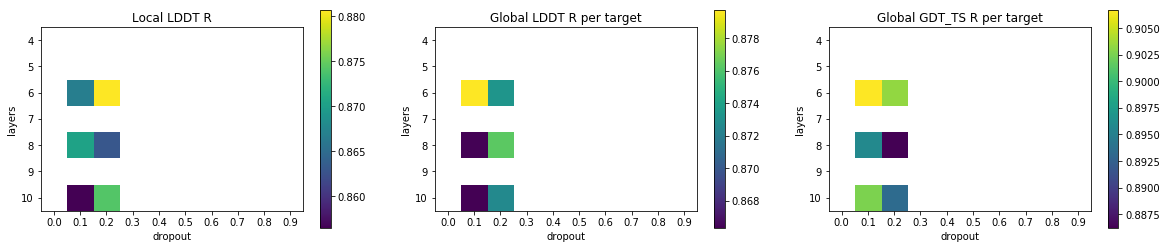

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(20,4))

df_dropout_layers = df.groupby(by=[ix['hp', 'model', 'dropout'], ix['hp', 'model', 'layers']]) \
    .apply(lambda df: df.metric.max()) \
    .reindex(pd.MultiIndex.from_product([np.linspace(0, 1, 10, endpoint=False).round(1), range(4, 11)], names=['dropout', 'layers'])) \
    .unstack('dropout')

metrics = {
    'Local LDDT R': df_dropout_layers['local_lddt', 'pearson'], 
    'Global LDDT R per target': df_dropout_layers['global_lddt', 'per_target_pearson'], 
    'Global GDT_TS R per target': df_dropout_layers['global_gdtts', 'per_target_pearson'], 
}

for ax, (title, df_img) in zip(axes, metrics.items()):
    im=ax.imshow(df_img.values)
    ax.set_title(title)
    ax.set_xlabel('dropout')
    ax.set_xticks(range(len(df_img.columns.get_level_values('dropout'))))
    ax.set_xticklabels(df_img.columns.get_level_values('dropout'))
    ax.set_ylabel('layers')
    ax.set_yticks(range(len(df_img.index.get_level_values('layers'))))
    ax.set_yticklabels(df_img.index.get_level_values('layers'))
    plt.colorbar(im, ax=ax)
    display(df_img.style.set_caption(title).applymap(lambda v: 'opacity:.2' if np.isnan(v) else ''))

### Node Encoding (group by and take best)

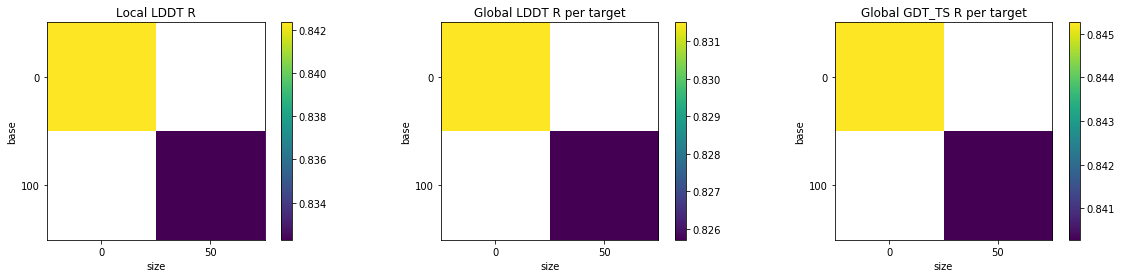

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(20,4))

df_encsize_encbase = df.fillna({('hp', 'data', 'encoding_base', ''): 0}) \
    .groupby(by=[ix['hp', 'data', 'encoding_size'], ix['hp', 'data', 'encoding_base']]) \
    .apply(lambda df: df.metric.mean())
df_encsize_encbase.index.names = ['enc size', 'enc base']
df_encsize_encbase = df_encsize_encbase.unstack('enc size')

metrics = {
    'Local LDDT R': df_encsize_encbase['local_lddt', 'pearson'], 
    'Global LDDT R per target': df_encsize_encbase['global_lddt', 'per_target_pearson'], 
    'Global GDT_TS R per target': df_encsize_encbase['global_gdtts', 'per_target_pearson'], 
}

for ax, (title, df_img) in zip(axes, metrics.items()):
    im=ax.imshow(df_img.values)
    ax.set_title(title)
    ax.set_xlabel('size')
    ax.set_xticks(range(len(df_img.columns.get_level_values('enc size'))))
    ax.set_xticklabels(df_img.columns.get_level_values('enc size'))
    ax.set_ylabel('base')
    ax.set_yticks(range(len(df_img.index.get_level_values('enc base'))))
    ax.set_yticklabels(df_img.index.get_level_values('enc base'))
    plt.colorbar(im, ax=ax)
    display(df_img.style.set_caption(title).applymap(lambda v: 'opacity:.2' if np.isnan(v) else ''))

## Separation vs cutoff (group by and take best)

separation,True
cutoff,
8,0.693307


separation,True
cutoff,
8,0.879746


separation,True
cutoff,
8,0.906672


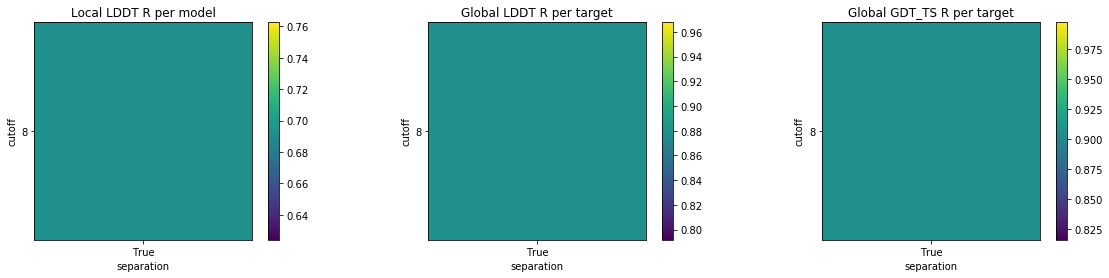

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(20,4))

df_sep_cutoff = df \
    .groupby(by=[ix['hp', 'data', 'separation'], ix['hp', 'data', 'cutoff']]) \
    .apply(lambda df: df.metric.max())
df_sep_cutoff.index.names = ['separation', 'cutoff']
df_sep_cutoff = df_sep_cutoff.unstack('separation')

metrics = {
    'Local LDDT R per model': df_sep_cutoff['local_lddt', 'per_model_pearson'], 
    'Global LDDT R per target': df_sep_cutoff['global_lddt', 'per_target_pearson'], 
    'Global GDT_TS R per target': df_sep_cutoff['global_gdtts', 'per_target_pearson'], 
}

for ax, (title, df_img) in zip(axes, metrics.items()):
    im=ax.imshow(df_img.values)
    ax.set_title(title)
    ax.set_xlabel('separation')
    ax.set_xticks(range(len(df_img.columns.get_level_values('separation'))))
    ax.set_xticklabels(df_img.columns.get_level_values('separation'))
    ax.set_ylabel('cutoff')
    ax.set_yticks(range(len(df_img.index.get_level_values('cutoff'))))
    ax.set_yticklabels(df_img.index.get_level_values('cutoff'))
    plt.colorbar(im, ax=ax)
    display(df_img.style.set_caption(title).applymap(lambda v: 'opacity:.2' if np.isnan(v) else ''))

## Sigma vs cutoff (group by and take best)

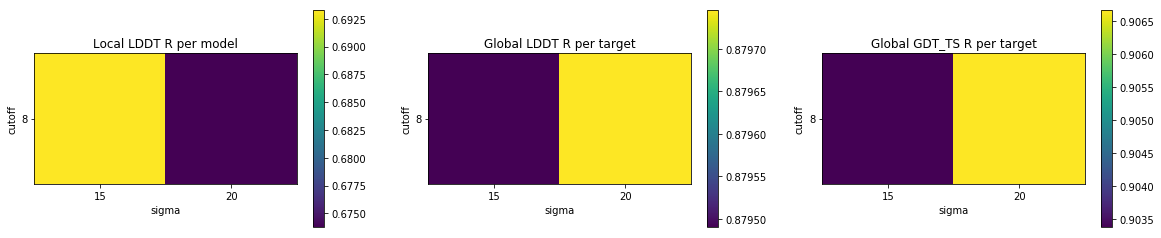

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(20,4))

df_encsize_encbase = df \
    .groupby(by=[ix['hp', 'data', 'sigma'], ix['hp', 'data', 'cutoff']]) \
    .apply(lambda df: df.metric.max())
df_encsize_encbase.index.names = ['sigma', 'cutoff']
df_encsize_encbase = df_encsize_encbase.unstack('sigma')

metrics = {
    'Local LDDT R per model': df_encsize_encbase['local_lddt', 'per_model_pearson'], 
    'Global LDDT R per target': df_encsize_encbase['global_lddt', 'per_target_pearson'], 
    'Global GDT_TS R per target': df_encsize_encbase['global_gdtts', 'per_target_pearson'], 
}

for ax, (title, df_img) in zip(axes, metrics.items()):
    im=ax.imshow(df_img.values)
    ax.set_title(title)
    ax.set_xlabel('sigma')
    ax.set_xticks(range(len(df_img.columns.get_level_values('sigma'))))
    ax.set_xticklabels(df_img.columns.get_level_values('sigma'))
    ax.set_ylabel('cutoff')
    ax.set_yticks(range(len(df_img.index.get_level_values('cutoff'))))
    ax.set_yticklabels(df_img.index.get_level_values('cutoff'))
    plt.colorbar(im, ax=ax)
    display(df_img.style.set_caption(title).applymap(lambda v: 'opacity:.2' if np.isnan(v) else ''))